# Decision Tree Model Construction to Predict Agency Type by Various Metrics

This script will construct a decision tree model that aims to predict what agency is being described based on various indicators of service reliability and/or overall service use. Dataframes containing information on MDBF (mean distance between failures) and estimated total ridership will be assessed.

In [175]:
# Import relevant packages
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

## Initial Data Cleaning/Merging

Inconsistencies between these data frames must be resolved and then merged in order to create an appropriate model. Ridership data is gathered daily while MDBF data is gathered on a monthly basis, so the ridership data is averaged by month in order to ensure that these data frames can be compared and merged. The MBDF data frame assesses MDBF by the type of train car and includes averages for their entire fleets, so any row for specific train car type is dropped.

In [132]:
# Read in appropriate data sets
mdbf = pd.read_csv("../../data/01-modified-data/MDBF-Cleaned-Merged.csv",index_col=0)
rides = pd.read_csv("../../data/01-modified-data/Daily-Ridership-Cleaned.csv",index_col=0)

# Typecast to date columns
mdbf['ServiceDate'] = pd.to_datetime(mdbf['ServiceDate'])
rides['Date'] = pd.to_datetime(rides['Date'])

# Find monthly averages in rides data frame
mean_rides = rides.groupby([pd.PeriodIndex(rides['Date'],freq='M'),'agency'])['total-ridership'].mean().reset_index()


# Rename and reformat columns for merging
mean_rides['Date'] = mean_rides['Date'].astype(str)
mean_rides['Date'] = pd.to_datetime(mean_rides['Date'])
mean_rides = mean_rides.rename(columns={"Date":"ServiceDate","agency":"Agency"})


# Join data frames by date and agency
df = mdbf.merge(mean_rides,on=['ServiceDate','Agency'])

# Remove columns not related to analysis (Date, FleetType)
df = df.drop(columns=["ServiceDate","FleetType"])
#mdbf.head()
#rides.head()
#df.head()

Now that the data is cleaned, it will now be split into a 70-30 train-test split (70-30 due to smaller sample size) for the decision tree to be fitted. Agencies are encoded as strings in the original data set, so they are coded as numbers for the analysis to be performed.

In [133]:
# Assign numerical codes to categories
# CAT CODE KEY: 0=LIRR, 1=MNR, 2=Subways
df['Agency_num'] = pd.Categorical(df['Agency'])
df['Agency_num'] = df['Agency_num'].cat.codes

X = df.drop(columns=['Agency','Agency_num'])
Y = df['Agency_num']

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.3)
print(type(x_train),x_train.shape)
print(type(x_test),x_test.shape)
print(type(y_train),y_train.shape)
print(type(y_test),y_test.shape)

<class 'pandas.core.frame.DataFrame'> (42, 2)
<class 'pandas.core.frame.DataFrame'> (19, 2)
<class 'pandas.core.series.Series'> (42,)
<class 'pandas.core.series.Series'> (19,)


First, a random model will be fitted to compare the subsequent decision tree model to. This random model will be generated based on the frequency of Agency type within the training data set generated above.

In [134]:
# Model determined by probabilities of positive and negative in the training data
# proability of negative opinion in training data set
p_mnr = y_train.value_counts()[0]/len(y_train)
p_sub = y_train.value_counts()[1]/len(y_train)
p_lirr = y_train.value_counts()[2]/len(y_train)

# Set seed for reproducibility
np.random.seed(717)

# Randomly drawn array from uniform distribution based on above probabilities that serves as a prediction
yp_train = np.random.choice(np.arange(0,3),p=[p_mnr,p_sub,p_lirr],size=len(y_train))

# Predict based on same probability for test data set
yp_test = np.random.choice(np.arange(0,3),p=[p_mnr,p_sub,p_lirr],size=len(y_test))

# Print classification report
print("CLASSIFICATION REPORT FOR TRAINING SET")
print(classification_report(y_train,yp_train,target_names=["LIRR","MNR","Subway"]))
print("CLASSIFICATION REPORT FOR TEST SET")
print(classification_report(y_test,yp_test,target_names=["LIRR","MNR","Subway"]))

CLASSIFICATION REPORT FOR TRAINING SET
              precision    recall  f1-score   support

        LIRR       0.50      0.36      0.42        11
         MNR       0.35      0.38      0.36        16
      Subway       0.35      0.40      0.38        15

    accuracy                           0.38        42
   macro avg       0.40      0.38      0.39        42
weighted avg       0.39      0.38      0.38        42

CLASSIFICATION REPORT FOR TEST SET
              precision    recall  f1-score   support

        LIRR       0.50      0.33      0.40         6
         MNR       0.67      0.40      0.50         5
      Subway       0.67      1.00      0.80         8

    accuracy                           0.63        19
   macro avg       0.61      0.58      0.57        19
weighted avg       0.61      0.63      0.59        19



Now, a decision tree model will be fitted to the same data sets and compared to the prior random model.

In [178]:
model = Pipeline([
    ('feature_selection', SelectFromModel(tree.DecisionTreeClassifier())),
    ('classification', tree.DecisionTreeClassifier())
])


model = model.fit(x_train,y_train)

# Save predictions for later plot use
yp_train = model.predict(x_train)
yp_test = model.predict(x_test)

# Print classification report
print("CLASSIFICATION REPORT FOR TRAINING SET")
print(classification_report(y_train,yp_train,target_names=["LIRR","MNR","Subway"]))
print("CLASSIFICATION REPORT FOR TEST SET")
print(classification_report(y_test,yp_test,target_names=["LIRR","MNR","Subway"]))

CLASSIFICATION REPORT FOR TRAINING SET
              precision    recall  f1-score   support

        LIRR       1.00      1.00      1.00        13
         MNR       1.00      1.00      1.00        13
      Subway       1.00      1.00      1.00        16

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42

CLASSIFICATION REPORT FOR TEST SET
              precision    recall  f1-score   support

        LIRR       0.40      0.50      0.44         4
         MNR       0.71      0.62      0.67         8
      Subway       1.00      1.00      1.00         7

    accuracy                           0.74        19
   macro avg       0.70      0.71      0.70        19
weighted avg       0.75      0.74      0.74        19



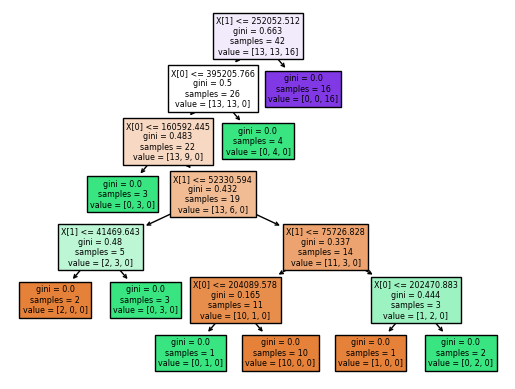

In [174]:
fig = plt.figure()
tree_plot = tree.plot_tree(model,filled=True)

We can see that this decision tree is overfitted considering the perfect accuracy in predicting the training data values but variable accuracy in predicting test data values. Thus, hyperparameter tuning will be undertaken below.

# Feature Selection

In [136]:
# Generate html file as built=in vscode functionality does not work
os.system('jupyter nbconvert --to html Agency-Decision-Trees.ipynb')

0